<a href="https://colab.research.google.com/github/ebharucha/kaggle/blob/master/Predicting_Molecular_Properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Molecular Properties - kaggle

This challenge aims to predict interactions between atoms. Imaging technologies like MRI enable us to see and understand the molecular composition of tissues. Nuclear Magnetic Resonance (NMR) is a closely related technology which uses the same principles to understand the structure and dynamics of proteins and molecules.

Researchers around the world conduct NMR experiments to further understanding of the structure and dynamics of molecules, across areas like environmental science, pharmaceutical science, and materials science.

**The challenge is to develop an algorithm that can predict the magnetic interaction between two atoms in a molecule (i.e., the scalar coupling constant).**

Using NMR to gain insight into a molecule’s structure and dynamics depends on the ability to accurately predict so-called “scalar couplings”. These are effectively the magnetic interactions between a pair of atoms. The strength of this magnetic interaction depends on intervening electrons and chemical bonds that make up a molecule’s three-dimensional structure.


_The work below references contributions from various individuals posting on kaggle & elsewhere._<br>

<font size=1>
<a href="https://www.kaggle.com/danofer/bonds-from-structure-data/output" target ="_blank">Bonds from structure data
</a>  by Dan Ofer,&nbsp
<a href="https://www.kaggle.com/artgor/molecular-properties-eda-and-models" target ="_blank">Molecular Properties EDA and models</a>  by Andrew Lukyanenko,&nbsp
<a href="https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb" target ="_blank">Giba R + data.table + Simple Features -1.012 LB</a>  by Giba<br>
</font>

# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Dependencies

In [0]:
# Install dependencies

# !pip install catboost
!pip install scikit-optimize


     |████████████████████████████████| 81kB 6.9MB/s 


In [0]:
# Import dependencies

import gc
import os
import glob
from warnings import simplefilter
import pickle
import re

import math
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import lightgbm as lgb
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

# import warnings filter
import warnings
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Scale data function

In [0]:
def scale(scaler, data):
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
  if (scaler == 'standard'):
    std_scaler = StandardScaler()
    return (std_scaler.fit_transform(data))
  elif (scaler == 'minmax'):
    minmax_scaler = MinMaxScaler(feature_range=(-1,1))
    return (minmax_scaler.fit_transform(data))

# Import dataset from kaggle

In [0]:
#to access kaggle datasets
!pip install kaggle

# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [0]:
# download data

!kaggle competitions download -c champs-scalar-coupling

#!ls '/content/gdrive/My Drive/Colab Notebooks/data1/Molecular_Properties/data'

# !unzip '/content/gdrive/My Drive/Colab Notebooks/data1/Molecular_Properties/magnetic_shielding_tensors.csv.zip' \
# -d '/content/gdrive/My Drive/Colab Notebooks/data1/Molecular_Properties/data/'

# Load data

In [0]:
# path = '/content/gdrive/My Drive/Colab Notebooks/data1/Molecular_Properties/data'
# files = ['train.csv', 'structures.csv', 'dipole_moments.csv', 'magnetic_shielding_tensors.csv', 'mulliken_charges.csv', 
#          'potential_energy.csv', 'scalar_coupling_contributions.csv', 'tmp.csv']
# df = dict()

# for file in files:
#   file_prefix = file.split('.')[0]
#   df[file_prefix] = pd.read_csv(f'{path}/{file}')

# with open(f'{path}/df.pkl', 'wb') as pklfile:
#   pickle.dump(df, pklfile)

In [0]:
path_1 = '/content/gdrive/My Drive/Colab Notebooks/data1/Molecular_Properties/data'
path_2 = '/content/gdrive/My Drive/Colab Notebooks/data2/Molecular_Properties/data'

###### Dictionary of training data in separate dataframes - non-encoded ######
# with open(f'{path_1}/df.pkl', 'rb') as pklfile:
#   df = pickle.load(pklfile)
#------------------------------------------------------------------------#
###### Full training & test data with additional features - non-encoded ######
# with open(f'{path_1}/features/df_train.pkl', 'rb') as pklfile:
#   df_train = pickle.load(pklfile)

# with open(f'{path_1}/features/df_test.pkl', 'rb') as pklfile:
#   df_test = pickle.load(pklfile)
#------------------------------------------------------------------------#
###### Full training & test data with additional features - encoded ######
# with open(f'{path_1}/features/df_train_en.pkl', 'rb') as pklfile:
#   df_train_en = pickle.load(pklfile)

# with open(f'{path_1}/features/df_test_en.pkl', 'rb') as pklfile:
#   df_test_en = pickle.load(pklfile)
#------------------------------------------------------------------------#
###### Full training & test data with GIBA, QM9 features - encoded ######
# with open(f'{path_2}/features/df_train_en_2.pkl', 'rb') as pklfile:
#   df_train_en = pickle.load(pklfile)

# with open(f'{path_1}/features/df_test_en.pkl', 'rb') as pklfile:
#   df_test_en_ = pickle.load(pklfile)
#------------------------------------------------------------------------#
###### Training & test data with GIBA features - encoded ######
with open(f'{path_2}/features/df_train_en_1.pkl', 'rb') as pklfile:
  df_train_en_1 = pickle.load(pklfile)

with open(f'{path_2}/features/df_test_en_1.pkl', 'rb') as pklfile:
  df_test_en_1 = pickle.load(pklfile)
#------------------------------------------------------------------------#
###### Training & test data with QM9 features - encoded ######
# with open(f'{path_2}/features/df_train_en_2.pkl', 'rb') as pklfile:
#   df_train_en_2 = pickle.load(pklfile)

# with open(f'{path_2}/features/df_test_en_2.pkl', 'rb') as pklfile:
#   df_test_en_2 = pickle.load(pklfile)
#------------------------------------------------------------------------#
###### Test ids ######
with open(f'{path_2}/features/test_id.pkl', 'rb') as pklfile:
  test_id = pickle.load(pklfile)

#------------------------------------------------------------------------#
###### Target ######  
with open(f'{path_1}/features/y.pkl', 'rb') as pklfile:
  y = pickle.load(pklfile)
  
gc.collect()

101

In [0]:
cols_nan = df_train_en_1.columns[df_train_en_1.isna().any()].tolist()

In [0]:
df_train_en_1.drop(columns=cols_nan, inplace=True)
df_test_en_1.drop(columns=cols_nan, inplace=True)

In [0]:
df_train_en_1.shape, df_test_en_1.shape

((4658147, 104), (2505542, 104))

In [0]:
cols = ['molecule_name', 'atom_index_0', 'atom_index_1','x_atom0', 'y_atom0', 'z_atom0',              'x_atom1', 'y_atom1', 'z_atom1', 'dist_atom0_atom1',             '1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH']
# df_train_en_1_ = df_train_en_1[cols]
df_test_en_1_ = df_test_en_1[cols]

# EDA

Predict the *scalar_coupling_constant* between atom pairs in molecules, given the two atom *types (e.g., C and H), the coupling type (e.g., 2JHC)*, and any features you are able to create from the molecule structure (xyz) files.

*   **train.csv** - the training set, where the first column (molecule_name_) is the name of the molecule where the coupling constant originates (the corresponding XYZ file is located at ./structures/.xyz), the second (atom_index_0) and third column (atom_index_1) is the atom indices of the atom-pair creating the coupling and the fourth column (scalar_coupling_constant) is the scalar coupling constant that we want to be able to predict
*   **structures.csv** - contains one line for each atom (H for hydrogen, C for carbon etc.) in a molecule, alongwith its X, Y and Z cartesian coordinates (a standard format for chemists and molecular visualization programs) 
*   **dipole_moments.csv** - contains the molecular electric dipole moments. These are three dimensional vectors that indicate the charge distribution in the molecule. The first column (molecule_name) are the names of the molecule, the second to fourth column are the X, Y and Z components respectively of the dipole moment.
*   **magnetic_shielding_tensors.csv** - contains the magnetic shielding tensors for all atoms in the molecules. The first column (molecule_name) contains the molecule name, the second column (atom_index) contains the index of the atom in the molecule, the third to eleventh columns contain the XX, YX, ZX, XY, YY, ZY, XZ, YZ and ZZ elements of the tensor/matrix respectively.
*   **mulliken_charges.csv** - contains the mulliken charges for all atoms in the molecules. The first column (molecule_name) contains the name of the molecule, the second column (atom_index) contains the index of the atom in the molecule, the third column (mulliken_charge) contains the mulliken charge of the atom.
*   **potential_energy.csv** - contains the potential energy of the molecules. The first column (molecule_name) contains the name of the molecule, the second column (potential_energy) contains the potential energy of the molecule.
*   **scalar_coupling_contributions.csv** - The scalar coupling constants in train.csv (or corresponding files) are a sum of four terms. scalar_coupling_contributions.csv contain all these terms. The first column (molecule_name) are the name of the molecule, the second (atom_index_0) and third column (atom_index_1) are the atom indices of the atom-pair, the fourth column indicates the type of coupling, the fifth column (fc) is the Fermi Contact contribution, the sixth column (sd) is the Spin-dipolar contribution, the seventh column (pso) is the Paramagnetic spin-orbit contribution and the eighth column (dso) is the Diamagnetic spin-orbit contribution.

In [0]:
gc.collect()

0

In [0]:
print (f"# of unique molecule names in train dataset = {df['train']['molecule_name'].nunique()}")
print (f"# of unique molecule types in train dataset = {df['train']['type'].nunique()}")


In [0]:
df['structures'].head()

In [0]:
tmp = df['structures']['atom'].str.contains(pat = '[CHNO]', regex = True)
print (f"# of unique molecule names with 'C', 'H', 'N', 'O' atoms in structures dataset = {df['structures'][tmp]['molecule_name'].nunique()}")

In [0]:
molecule_names = df['structures']['molecule_name'].unique()
df['structures'][df['structures']['molecule_name'] == 'dsgdb9nsd_000001']

In [0]:
df['train'].groupby('type').count()

,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant
type,,,,,
1JHC,709416,709416,709416,709416,709416
1JHN,43363,43363,43363,43363,43363
2JHC,1140674,1140674,1140674,1140674,1140674
2JHH,378036,378036,378036,378036,378036
2JHN,119253,119253,119253,119253,119253
3JHC,1510379,1510379,1510379,1510379,1510379
3JHH,590611,590611,590611,590611,590611
3JHN,166415,166415,166415,166415,166415


In [0]:
df['test'].groupby('type').count()

,id,molecule_name,atom_index_0,atom_index_1
type,,,,
1JHC,380609,380609,380609,380609
1JHN,24195,24195,24195,24195
2JHC,613138,613138,613138,613138
2JHH,203126,203126,203126,203126
2JHN,64424,64424,64424,64424
3JHC,811999,811999,811999,811999
3JHH,317435,317435,317435,317435
3JHN,90616,90616,90616,90616


In [0]:
df['train']['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

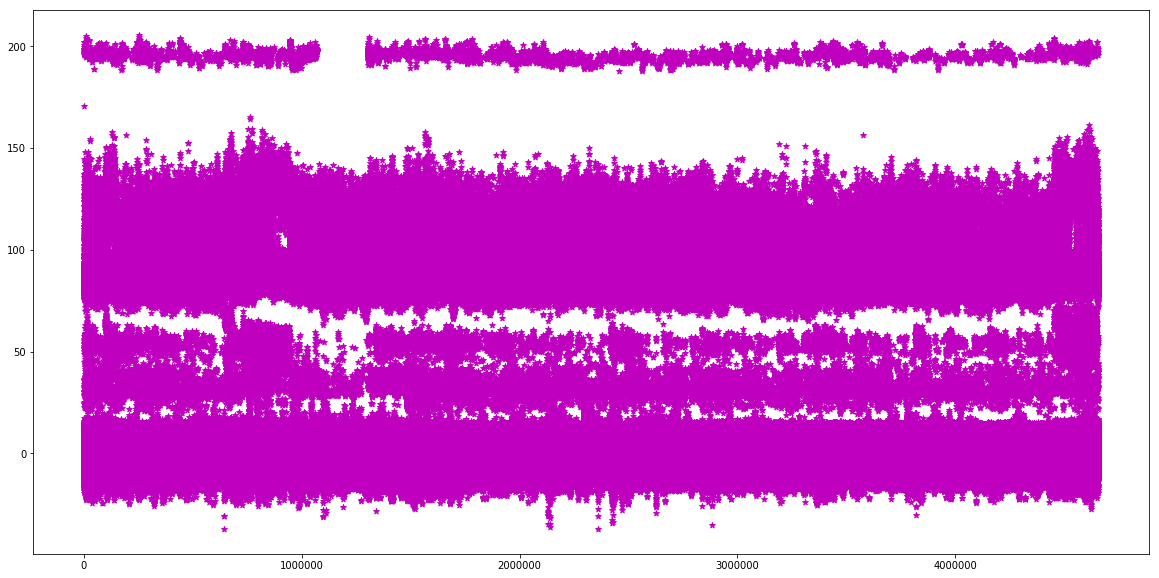

In [0]:
idx=df_train_en.index.values[::]
plt.figure(figsize=(20,10))
# plt.plot(df_train_en.fc[0:1000:10])
# plt.plot(df_train_en.fc[1000:2000:10],'r')
# plt.plot(y[:2000:10],'g--')
plt.scatter(idx,df_train_en.fc[::],c='m',marker='*')
plt.show()

In [0]:
idx.shape, df_train_en[:2000:10].shape

((200,), (200, 57))

# Feature Engineering for Train Data

https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)

https://www.kaggle.com/danofer/bonds-from-structure-data/output

## Structures - Atom distance

In [0]:
# Train data, distance computation using 'structures'

df_train = df['train']

df_train = df_train.merge(df['structures'], left_on=['molecule_name','atom_index_0'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index', 'atom'])
df_train.rename(columns={'x':'x_atom0', 'y':'y_atom0', 'z':'z_atom0'}, inplace=True)

df_train = df_train.merge(df['structures'], left_on=['molecule_name','atom_index_1'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index', 'atom'])
df_train.rename(columns={'x':'x_atom1', 'y':'y_atom1', 'z':'z_atom1'}, inplace=True)

df_train['dist_atom0_atom1'] = np.sqrt( (df_train['x_atom0']-df_train['x_atom1'])**2 + (df_train['y_atom0']-df_train['y_atom1'])**2 
                                        + (df_train['z_atom0']-df_train['z_atom1'])**2 )

df_train['dist_x_atom0_atom1'] = (df_train_['x_atom0']-df_train['x_atom1'])
df_train['dist_y_atom0_atom1'] = (df_train['y_atom0']-df_train['y_atom1'])
df_train['dist_z_atom0_atom1'] = (df_train['z_atom0']-df_train['z_atom1'])

df_train.drop(columns=['scalar_coupling_constant'], inplace=True)

# Test data, distance computation using 'structures'

df_test = df['test']

df_test = df_test.merge(df['structures'], left_on=['molecule_name','atom_index_0'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index', 'atom'])
df_test.rename(columns={'x':'x_atom0', 'y':'y_atom0', 'z':'z_atom0'}, inplace=True)

df_test = df_test.merge(df['structures'], left_on=['molecule_name','atom_index_1'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index', 'atom'])
df_test.rename(columns={'x':'x_atom1', 'y':'y_atom1', 'z':'z_atom1'}, inplace=True)

df_test['dist_atom0_atom1'] = np.sqrt( (df_test['x_atom0']-df_test['x_atom1'])**2 + (df_test['y_atom0']-df_test['y_atom1'])**2 
                                        + (df_test['z_atom0']-df_test['z_atom1'])**2 )

df_test['dist_x_atom0_atom1'] = (df_test['x_atom0']-df_test['x_atom1'])
df_test['dist_y_atom0_atom1'] = (df_test['y_atom0']-df_test['y_atom1'])
df_test['dist_z_atom0_atom1'] = (df_test['z_atom0']-df_test['z_atom1'])

In [0]:
gc.collect()

645

## Dipole Moments

In [0]:
# Train data, Dipole Moments

df_train = df_train.merge(df['dipole_moments'], on='molecule_name', how='left')
df_train.rename(columns={'X':'dipole_X', 'Y':'dipole_Y', 'Z':'dipole_Z'}, inplace=True)

In [0]:
gc.collect()

0

## Magnetic Shielding Tensors

In [0]:
# Train data, Magnetic Shielding Tensors

df_train = df_train.merge(df['magnetic_shielding_tensors'], left_on=['molecule_name','atom_index_0'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index'])
df_train.rename(columns={'XX':'XX_atom0', 'YX':'YX_atom0', 'ZX':'ZX_atom0', 'XY':'XY_atom0', 'YY':'YY_atom0', 'ZY':'ZY_atom0', 'XZ':'XZ_atom0', 'YZ':'YZ_atom0', 'ZZ':'ZZ_atom0'}, inplace=True)

df_train = df_train.merge(df['magnetic_shielding_tensors'], left_on=['molecule_name','atom_index_1'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index'])
df_train.rename(columns={'XX':'XX_atom1', 'YX':'YX_atom1', 'ZX':'ZX_atom1', 'XY':'XY_atom1', 'YY':'YY_atom1', 'ZY':'ZY_atom1', 'XZ':'XZ_atom1', 'YZ':'YZ_atom1', 'ZZ':'ZZ_atom1'}, inplace=True)

## Mulliken Charges

In [0]:
# Train data, Mulliken Charges

df_train = df_train.merge(df['mulliken_charges'], left_on=['molecule_name','atom_index_0'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index'])
df_train.rename(columns={'mulliken_charge':'mulliken_charge0'}, inplace=True)

df_train = df_train.merge(df['mulliken_charges'], left_on=['molecule_name','atom_index_1'], right_on=['molecule_name','atom_index'], how='left').drop(columns=['atom_index'])
df_train.rename(columns={'mulliken_charge':'mulliken_charge1'}, inplace=True)

In [0]:
gc.collect()

65

## Potential Energy

In [0]:
# Train data

df_train = df_train.merge(df['potential_energy'], on='molecule_name', how='left')

In [0]:
gc.collect()

18

## Scalar Coupling Contributions

In [0]:
# Train data

df_train = df_train.merge(df['scalar_coupling_contributions'], on=['molecule_name','atom_index_0', 'atom_index_1', 'type'], how='left')

## Miscellaneous Others

In [0]:
atomic_radius_values = [0.38, 0.77, 0.75, 0.73, 0.71]
electronegativity_values = [2.2, 2.55, 3.04, 3.44, 3.98]

# Radius, Electronegativity - Train data

df_train['no_of_bonds'] = df['train']['type'].str[0]
df_train['atom'] = df['train']['type'].str[3]

conditions = [(df_train['atom'] == 'H'),(df_train['atom'] == 'C'),(df_train['atom'] == 'N'),(df_train['atom'] == 'O'),(df_train['atom'] == 'F')]

df_train['atomic_radius'] = np.select(conditions, atomic_radius_values)

df_train['electronegativity'] = np.select(conditions, electronegativity_values)

# Radius, Electronegativity - Test data

df_test['no_of_bonds'] = df['train']['type'].str[0]
df_test['atom'] = df['train']['type'].str[3]

conditions = [(df_test['atom'] == 'H'),(df_test['atom'] == 'C'),(df_test['atom'] == 'N'),(df_test['atom'] == 'O'),(df_test['atom'] == 'F')]

df_test['atomic_radius'] = np.select(conditions, atomic_radius_values)

df_test['electronegativity'] = np.select(conditions, electronegativity_values)

In [0]:
# Mean & standard deviation of x,y,z distances between atom0 & atom1, total # of bonds per molecule - Train data

df_train['no_of_bonds'] = pd.to_numeric(df_train['no_of_bonds'])
df_train['mean_dist_xyz_atom0_atom1'] = df_train[['dist_x_atom0_atom1','dist_y_atom0_atom1','dist_z_atom0_atom1']].mean(axis=1)
df_train['std_dist_xyz_atom0_atom1'] = df_train[['dist_x_atom0_atom1','dist_y_atom0_atom1','dist_z_atom0_atom1']].std(axis=1)
df_train['total_bonds_molecule'] = df_train.groupby(['molecule_name'])['no_of_bonds'].transform('sum')

# Mean & standard deviation of x,y,z distances between atom0 & atom1, total # of bonds per molecule - Test data

df_test['no_of_bonds'] = pd.to_numeric(df_test['no_of_bonds'])
df_test['mean_dist_xyz_atom0_atom1'] = df_test[['dist_x_atom0_atom1','dist_y_atom0_atom1','dist_z_atom0_atom1']].mean(axis=1)
df_test['std_dist_xyz_atom0_atom1'] = df_test[['dist_x_atom0_atom1','dist_y_atom0_atom1','dist_z_atom0_atom1']].std(axis=1)
df_test['total_bonds_molecule'] = df_test.groupby(['molecule_name'])['no_of_bonds'].transform('sum')

,id,molecule_name,atom_index_0,atom_index_1,x_atom0,y_atom0,z_atom0,x_atom1,y_atom1,z_atom1,dist_atom0_atom1,dist_x_atom0_atom1,dist_y_atom0_atom1,dist_z_atom0_atom1,dipole_X,dipole_Y,dipole_Z,XX_atom0,YX_atom0,ZX_atom0,XY_atom0,YY_atom0,ZY_atom0,XZ_atom0,YZ_atom0,ZZ_atom0,XX_atom1,YX_atom1,ZX_atom1,XY_atom1,YY_atom1,ZY_atom1,XZ_atom1,YZ_atom1,ZZ_atom1,mulliken_charge0,mulliken_charge1,potential_energy,fc,sd,pso,dso,no_of_bonds,atomic_radius,electronegativity,mean_dist_xyz_atom0_atom1,std_dist_xyz_atom0_atom1,total_bonds_molecule,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,C,H
4658142,4658142,85002,17,4,1.12655,-1.348733,-1.933838,1.629865,-0.747236,0.235262,2.306538,-0.503315,-0.601497,-2.169100,1.3623,1.4058,-0.0,30.1753,-6.4689,-5.5474,-3.8417,30.4761,6.3612,-1.538,4.0582,29.4963,175.509,-26.4784,0.0000,-32.8936,140.669,0.0002,0.0012,0.0002,136.0550,0.090746,-0.064218,-364.8726,3.586440,0.019741,0.150477,-0.213205,2,0.77,2.55,1.773373,2.539438,191,0,0,1,0,0,0,0,1,0
4658143,4658143,85002,17,5,1.12655,-1.348733,-1.933838,1.415947,0.620773,0.939122,3.495226,-0.289397,-1.969506,-2.872960,1.3623,1.4058,-0.0,30.1753,-6.4689,-5.5474,-3.8417,30.4761,6.3612,-1.538,4.0582,29.4963,164.864,2.7385,-0.0001,-0.5899,170.042,0.0002,-0.0002,0.0003,143.3250,0.090746,-0.367733,-364.8726,0.674583,-0.007276,0.305078,-0.403388,3,0.77,2.55,4.072202,4.088502,191,0,0,0,0,0,1,0,1,0
4658144,4658144,85002,17,6,1.12655,-1.348733,-1.933838,-0.027076,0.747033,0.478506,3.397424,1.153626,-2.095765,-2.412345,1.3623,1.4058,-0.0,30.1753,-6.4689,-5.5474,-3.8417,30.4761,6.3612,-1.538,4.0582,29.4963,140.819,1.6914,-0.0002,39.5850,168.697,-0.0006,-0.0002,-0.0006,103.1220,0.090746,0.255121,-364.8726,1.337470,-0.028423,0.312240,-0.447920,3,0.77,2.55,3.847497,2.293324,191,0,0,0,0,0,1,0,1,0
4658145,4658145,85002,17,7,1.12655,-1.348733,-1.933838,-0.131901,0.356983,-1.010196,2.312202,1.258451,-1.705716,-0.923642,1.3623,1.4058,-0.0,30.1753,-6.4689,-5.5474,-3.8417,30.4761,6.3612,-1.538,4.0582,29.4963,120.230,-6.9030,9.9705,-18.4385,109.995,-28.7188,1.5550,-9.5259,89.9291,0.090746,0.010044,-364.8726,4.800620,0.139202,-0.053102,-0.124710,2,0.77,2.55,1.782093,1.042432,191,0,0,1,0,0,0,0,1,0
4658146,4658146,85002,17,8,1.12655,-1.348733,-1.933838,0.787756,-0.840138,-1.042152,1.080997,0.338794,-0.508595,-0.891687,1.3623,1.4058,-0.0,30.1753,-6.4689,-5.5474,-3.8417,30.4761,6.3612,-1.538,4.0582,29.4963,196.186,-21.3617,-7.9868,-20.3374,153.352,-11.5942,1.4018,-11.3754,144.3610,0.090746,-0.097191,-364.8726,115.975000,0.378277,0.450213,1.130600,1,0.77,2.55,0.389518,0.358541,191,1,0,0,0,0,0,0,1,0


In [0]:
## ###y = df_train_en.iloc[:50000:500, :]

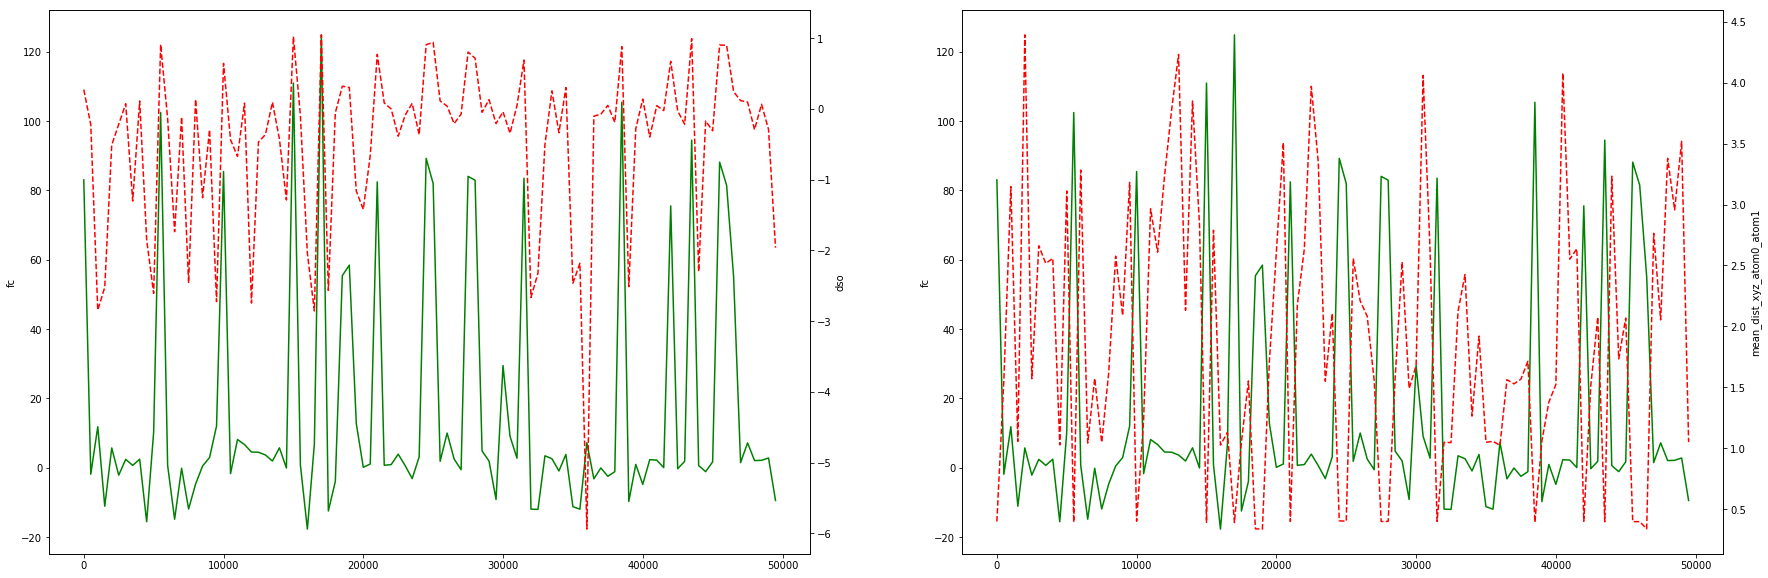

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,10))
ax1.plot (df.index.values, df.fc, 'g')
ax1.set_ylabel('fc')
ax1_1 = ax1.twinx()
ax1_1.plot(df.index.values, df.dso, 'r--')
ax1_1.set_ylabel('dso')

ax2.plot (df.index.values, df.fc, 'g')
ax2.set_ylabel('fc')
ax2_1 = ax2.twinx()
ax2_1.plot(df.index.values, df.mean_dist_xyz_atom0_atom1, 'r--')
ax2_1.set_ylabel('mean_dist_xyz_atom0_atom1')
plt.show()


In [0]:
('dist_atom0_atom1', -0.668662773759264)
('fc', 0.999920920307853)
('dso', 0.5569578710668175)
('no_of_bonds', -0.7089133647431195)
('mean_dist_xyz_atom0_atom1', -0.5557884443077478)
('1JHC', 0.9589608898833502)
('scalar_coupling_constant', 1.0)

,id,molecule_name,atom_index_0,atom_index_1,x_atom0,y_atom0,z_atom0,x_atom1,y_atom1,z_atom1,dist_atom0_atom1,dist_x_atom0_atom1,dist_y_atom0_atom1,dist_z_atom0_atom1,no_of_bonds,atomic_radius,electronegativity,mean_dist_xyz_atom0_atom1,std_dist_xyz_atom0_atom1,total_bonds_molecule,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,C,H
0,4658147,0,2,0,-1.661639,0.0,1.0,0.599539,0.0,1.0,2.261178,-2.261178,0.0,0.0,1,0.77,2.55,1.704309,2.951949,8,0,0,1,0,0,0,0,1,0
1,4658148,0,2,1,-1.661639,0.0,1.0,-0.599539,0.0,1.0,1.062099,-1.062099,0.0,0.0,2,0.38,2.20,0.376018,0.651283,8,1,0,0,0,0,0,0,0,1
2,4658149,0,2,3,-1.661639,0.0,1.0,1.661639,0.0,1.0,3.323277,-3.323277,0.0,0.0,2,0.38,2.20,3.681390,6.376355,8,0,0,0,0,0,0,1,0,1
3,4658150,0,3,0,1.661639,0.0,1.0,0.599539,0.0,1.0,1.062099,1.062099,0.0,0.0,2,0.38,2.20,0.376018,0.651283,8,1,0,0,0,0,0,0,0,1
4,4658151,0,3,1,1.661639,0.0,1.0,-0.599539,0.0,1.0,2.261178,2.261178,0.0,0.0,1,0.77,2.55,1.704309,2.951949,8,0,0,1,0,0,0,0,1,0


## Clean data

In [0]:
# Train data

df_train_en = pd.DataFrame()

le = LabelEncoder()

# Label encode the "molecule_name" column
dfle = df_train
le = LabelEncoder()
dfle.molecule_name = le.fit_transform(dfle.molecule_name)

# One hot encode the "type" column
dummies = pd.get_dummies(dfle.type)
df_train_en = pd.concat([dfle,dummies],axis='columns')
df_train_en.drop(columns=['type', '3JHN'], inplace=True)

# One hot encode the "atom" column
dummies = pd.get_dummies(df_train_en.atom)
df_train_en = pd.concat([df_train_en,dummies],axis='columns')
df_train_en.drop(columns=['atom', 'N'], inplace=True)

In [0]:
# Test data

df_test_en = pd.DataFrame()

le = LabelEncoder()

# Label encode the "molecule_name" column
dfle = df_test
le = LabelEncoder()
dfle.molecule_name = le.fit_transform(dfle.molecule_name)

# One hot encode the "type" column
dummies = pd.get_dummies(dfle.type)
df_test_en = pd.concat([dfle,dummies],axis='columns')
df_test_en.drop(columns=['type', '3JHN'], inplace=True)

# One hot encode the "atom" column
dummies = pd.get_dummies(df_test_en.atom)
df_test_en = pd.concat([df_test_en,dummies],axis='columns')
df_test_en.drop(columns=['atom', 'N'], inplace=True)

# Feature Evaluation

## PCA

In [0]:
def pca (data):
  from sklearn.decomposition import PCA
  # pca = PCA(n_components=10)
  pca = PCA(.95)   # retain 95% of variance
  principalComponents_train = pca.fit_transform(data)
  pac_vars_train = [print (f'{pac_var*100:.2f}%\t', end="") for pac_var in pca.explained_variance_ratio_]
  print ()
  print (f'{np.sum(pca.explained_variance_ratio_)*100:.2f}%')
  return (principalComponents_train)

In [0]:
# X = df_train_en.iloc[:50000,:-1]
X = df_train_en_1
X_scaled = scale('standard', df_train_en_1)
pc = pca(X_scaled)

14.03%	11.12%	7.42%	7.22%	5.26%	4.95%	4.55%	3.16%	2.64%	2.50%	2.24%	1.99%	1.93%	1.79%	1.52%	1.47%	1.32%	1.24%	1.15%	1.13%	1.12%	1.10%	1.06%	1.01%	0.97%	0.96%	0.95%	0.90%	0.83%	0.80%	0.73%	0.70%	0.67%	0.67%	0.65%	0.59%	0.57%	0.51%	0.49%	0.48%	0.44%	0.42%	
95.25%


In [0]:
pc.shape
# gc.collect()

350

In [0]:
X_test_scaled = scale('standard', df_test_en_1)
pc_test = pca(X_test_scaled)

13.84%	8.98%	7.31%	6.45%	5.14%	4.72%	4.45%	3.12%	2.89%	2.55%	
59.44%


## Correlation

In [0]:
df_train_en['scalar_coupling_constant'] = y

In [0]:
corr = df_train_en.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')
# pd.DataFrame(corr.loc['scalar_coupling_constant']).transpose().style.background_gradient(cmap='coolwarm')
pd.DataFrame(corr).transpose().style.background_gradient(cmap='coolwarm')

In [0]:
for feature in corr['scalar_coupling_constant'].iteritems():
  if ((feature[1] >= 0.5) or (feature[1] <= -0.5)):
    print (feature)


('dist_atom0_atom1', -0.668662773759264)
('fc', 0.999920920307853)
('dso', 0.5569578710668175)
('no_of_bonds', -0.7089133647431195)
('mean_dist_xyz_atom0_atom1', -0.5557884443077478)
('1JHC', 0.9589608898833502)
('scalar_coupling_constant', 1.0)


In [0]:
train_fc = df_train_en[['dist_atom0_atom1', 'no_of_bonds', 'mean_dist_xyz_atom0_atom1', '1JHC', 'fc']]

In [0]:
corr.loc['fc'][[corr[feature] >= 0.5 for feature in corr.columns.tolist()]]

In [0]:
corr.loc['scalar_coupling_constant']

In [0]:
idx_feat = df_train_en.columns.get_loc('dso')
y = df_train_en.iloc[:50000,idx_feat]
X['dso'] = y

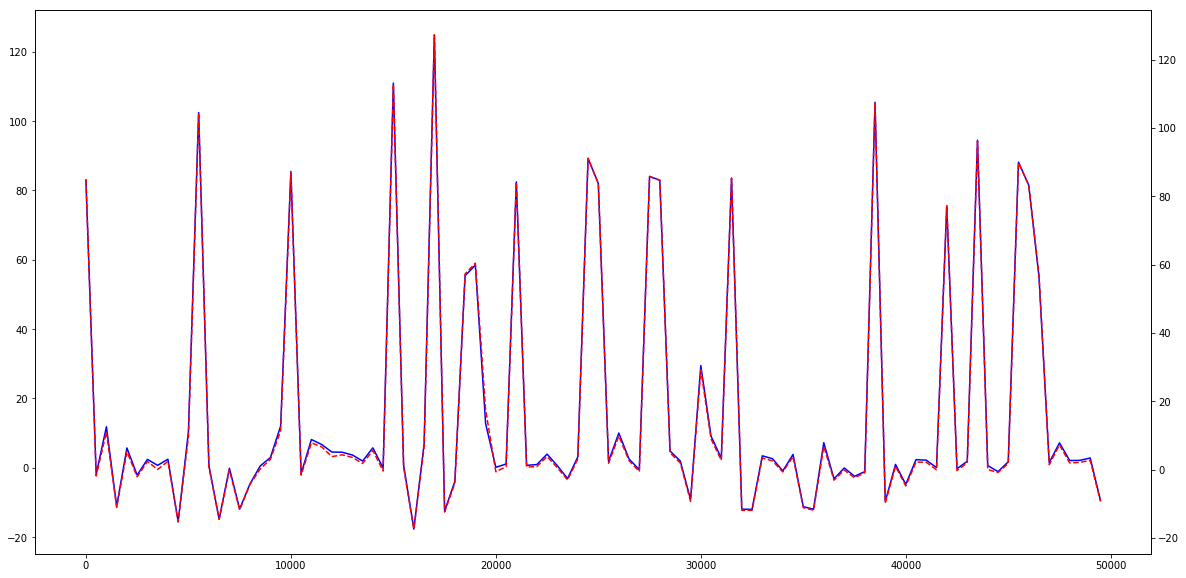

In [0]:
# f_dist_atom0_atom1 = df_train_en['dist_atom0_atom1'][:50000:500]
f_fc = df_train_en['fc'][:50000:500]


fig, ax1 = plt.subplots(figsize=(20,10))
# plt.plot(df_train_en.index[:50000:500], f_dist_atom0_atom1, 'b')
plt.plot(df_train_en.index[:50000:500], f_fc, 'b')

ax2 = ax1.twinx()
plt.plot(df_train_en.index[:50000:500], y[:50000:500], 'r--')

plt.show()

## Feature Importance

In [0]:
# Create sample of data

y_bak = y

cols = df_test_en.drop(columns=['id','molecule_name']).columns.tolist()

X_ = df_train_en.iloc[:50000,:]
X = df_train_en[cols].iloc[:50000,:]
# X = df_train_en[cols].iloc[1000000:1050000,1:-1]
X = X.reset_index().drop(columns=['index'])
X_scaled = scale('standard', X)

y = y_bak[:50000]
# y = y_bak[1000000:1050000]
y = y.reset_index().drop(columns=['index'])['scalar_coupling_constant']

gc.collect()

In [0]:
def feature_imp(regr_clf, X):
  threshold = 0.002
  # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
  feature_imp = pd.DataFrame(sorted(zip(regr_clf.feature_importances_,X.columns)), columns=['Value','Feature'])
  feature_imp_sorted = feature_imp.sort_values(by="Value", ascending=False)

  print (f'Threshold = {threshold}')
  print (feature_imp_sorted[feature_imp_sorted['Value'] >= threshold])
  plt.figure(figsize=(15, 12))
  sb.barplot(x="Value", y="Feature", data=feature_imp_sorted)
  plt.title(type(regr_clf))
  plt.show()

In [0]:
regr_lgb = lgb.LGBMRegressor(objective='regression_l1', metric='mae', n_estimators=50)
regr_lgb.fit(X_scaled, y)

In [0]:
regr_cat = CatBoostRegressor(verbose=False, task_type='GPU', eval_metric='MAE')
regr_cat.fit(X_scaled, y)

In [0]:
regr_rf = RandomForestRegressor(n_estimators=200, n_jobs=2)
regr_rf.fit(X_scaled, y)

Threshold = 0.002
       Value                    Feature
26  0.389557                no_of_bonds
25  0.299666  mean_dist_xyz_atom0_atom1
24  0.282686           dist_atom0_atom1
23  0.005615          electronegativity
22  0.005096                       1JHN
21  0.002665       total_bonds_molecule
20  0.002013                       1JHC


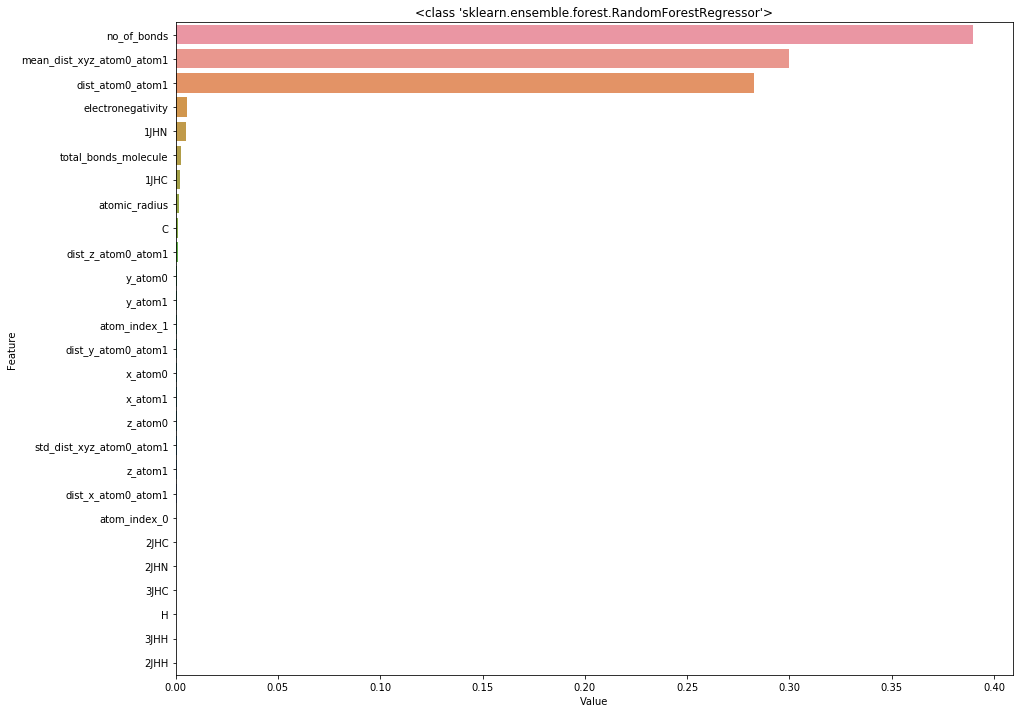

In [0]:
# feature_imp(regr_lgb, X)
# feature_imp(regr_cat, X)
feature_imp(regr_rf, X)

# Model & Evaluate with Train data


## Create Feature (X) & Target (y) datasets

In [0]:
# df_train_en_1.columns.tolist()

In [0]:
start_idx = 100000
end_idx = 150000
# end_idx = df_train_en.shape[0]

# cols = df_test_en.drop(columns=['id','molecule_name']).columns.tolist()
# cols = df_test_en.drop(columns=['id']).columns.tolist()
# cols = df_test_en_2.columns.tolist()

# X = df_train_en[cols].iloc[start_idx:end_idx:]
X = df_train_en_1.iloc[start_idx:end_idx:]
X_scaled = scale('standard', X)

# with open(f'{path_1}/features/y.pkl', 'rb') as pklfile:
#   y = pickle.load(pklfile)

y_ = y[start_idx:end_idx]
  
gc.collect()

X_scaled.shape, y_.shape

((50000, 107), (50000,))

In [0]:
X_scaled = scale('standard', df_train_en_1_)

In [0]:
X_scaled.shape

(4658147, 17)

## Parameter tuning

### hyperopt

In [0]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', 
                               [{'boosting_type': 'gbdt', 
                                    'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                 {'boosting_type': 'dart', 
                                     'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                 {'boosting_type': 'goss'}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [0]:
{'n_estimators': 1000 + hp.randint('n_estimators', 1500),
               'max_depth':  hp.choice('max_depth', [4, 5, 8, -1]),
               'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127]),
               'subsample': hp.uniform('subsample', 0.6, 1.0),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)}

In [0]:
from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

def objective(space):
    params = {
        'max_bin': space['max_bin'],
        'learning_rate': space['learning_rate'],
        'num_leaves': space['num_leaves'],
    }
    reg = lgb.LGBMRegressor(objective='regression_l1', metric='mae', n_estimators=200, **params)
    score = np.mean(cross_val_score(reg, X_scaled, y, cv=2, n_jobs=-1, scoring='neg_mean_absolute_error'))
    return score

space = {
    'max_bin': hp.choice('max_bin', np.arange(200, 400, 10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1.0)),
    'num_leaves': hp.choice('num_leaves', np.arange(30, 50, 1)),
    'boosting_type': hp.choice('boosting_type', 
                               [{'boosting_type': 'gbdt', 
                                    'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                 {'boosting_type': 'dart', 
                                     'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                 {'boosting_type': 'goss'}]),
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

print(best)                   

100%|██████████| 5/5 [00:17<00:00,  3.71s/it, best loss: -2.4861072315188952]
{'boosting_type': 0, 'gdbt_subsample': 0.7614557854467028, 'learning_rate': 0.05159145711268971, 'max_bin': 7, 'num_leaves': 3}


In [0]:
best

{'learning_rate': 0.013063217796912201, 'max_bin': 19, 'num_leaves': 5}

### skopt

In [0]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# LightGBM
reg = lgb.LGBMRegressor(objective='regression_l2', metric='mae', n_estimators=200, num_threads=2)
space  = [
#           Integer(200, 400, name='n_estimators'),
          Integer(200, 400, name='max_bin'),
          Real(10**-2, 10**0, "log-uniform", name='learning_rate'),
          Integer(10, 500, name='num_leaves'),
#           Integer(10, 50, name='min_data_in_leaf'),
#           Real(0.1, 1.0, name='bagging_fraction'),
#           Integer(1, 5, name='bagging_freq'),
#           Real(0.1, 1.0, name='feature_fraction')
         ]
                  
#Random Forrest
# reg = RandomForestRegressor(n_estimators=200,n_jobs=2)
# space  = [Integer(1,32, name='max_depth'),
#           Real(0.1, 1, name='min_samples_split'),
#           Integer(1, 5, name='min_samples_leaf'),
#           Integer(1, X_fc.shape[1], name='max_features'),
#          ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)
    return -np.mean(cross_val_score(reg, X_scaled, y, cv=2, n_jobs=-1, scoring='neg_mean_absolute_error'))

In [0]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
print (f'Best score={res_gp.fun:0.4f}')
for i in range(len(res_gp.x)):
  print (f'{space[i].name} = {res_gp.x[i]}, ',end='')

Best score=1.8989
max_bin = 327, learning_rate = 0.041914916257205975, num_leaves = 500, 

## cross_val_score

In [0]:
scores = cross_val_score(lgb.LGBMRegressor(
    objective='regression_l1', metric='mae', n_estimators=200
      ), 
      X_scaled, y, cv=2, n_jobs=-1, scoring='neg_mean_absolute_error')
np.average(scores)

-2.565528230026841

In [0]:
scores = cross_val_score(RandomForestRegressor(n_jobs=2), 
      X_scaled, y, cv=2, scoring='neg_mean_absolute_error')
np.average(scores)

-2.88316144184507

## Deep Learning Models



In [0]:
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import r2_score, mean_absolute_error

In [0]:
def plot_hist(history):
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values=history_dict['val_loss']
  plt.figure(figsize=(10,6))
  plt.xlabel('Epochs')
  plt.plot(loss_values, color='Blue', linestyle='dashed', marker='o', label='Training Loss')
  plt.plot(val_loss_values,color='Red', label='Validation Loss')
  plt.legend()
  plt.show()

def model1(X, y):
  name = 'Model 1'

  input_shape = X[0].shape

  model = Sequential()
  model.add(Dense(256, input_shape=input_shape, activation='softmax'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam', 
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

  # Runs model and assigns it to 'history'
  history = model.fit(X, y, epochs = 200, batch_size=32, validation_split = 0.2, verbose=0)

  y_pred = model.predict(X)
  print(f'{name}: The R2 score on the Train set is:\t{r2_score(y, y_pred):.3f}')
  print(f'{name}: The Mean Absolute Error on the Train set is:\t{mean_absolute_error(y, y_pred):.3f}')
  
  # Plot Training & Validation Loss
  plot_hist(history)
  
  return(model)

Model 1: The R2 score on the Train set is:	0.979
Model 1: The Mean Absolute Error on the Train set is:	2.424


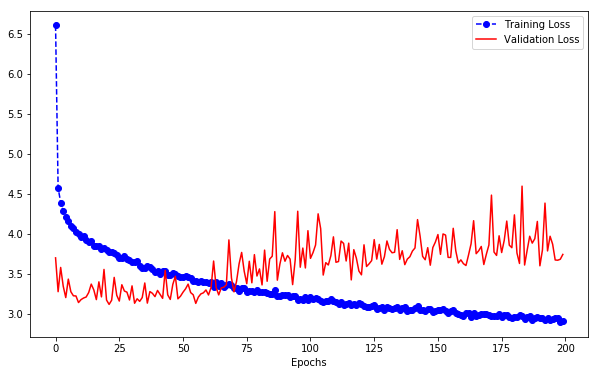

In [0]:
iters = 1

for iter in range(iters):
  model_1 = model1(X_scaled, y)

##Custom Scoring
$$score = \frac{1}{T} \sum_{t=1}^{T} \log \left( \frac{1}{n_{t}} \sum_{i=1}^{n_t} \lvert y_i - \hat{y_i} \rvert \right)$$
Where:

T is the number of scalar coupling types<br>
nt is the number of observations of type t$$<br>
yi is the actual scalar coupling constant for the observation<br>
yi^ is the predicted scalar coupling constant for the observation

In [0]:
# cols = df_test_en.drop(columns=['id','molecule_name']).columns.tolist()

cols =  ['molecule_name', 'atom_index_0', 'atom_index_1','x_atom0', 'y_atom0', 'z_atom0', 
            'x_atom1', 'y_atom1', 'z_atom1', 'dist_atom0_atom1',
            '1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH']
X_ = df_train_en[cols]
X = X_
X_scaled = scale('standard', X)

with open(f'{path}/features/y.pkl', 'rb') as pklfile:
  y = pickle.load(pklfile)

# X_test_scaled = scale('standard', df_test_en.drop(columns=['id','molecule_name'])) 
X_test_scaled = scale('standard', df_test_en[cols])
  
gc.collect()

156

In [0]:
X_ = X

In [0]:
X_scaled.shape, X_test_scaled.shape, y.shape

((4658147, 17), (2505542, 17), (4658147,))

In [0]:
# Score function

def compute_score (df_pred, coupling_types_):
  sum = 0
  for type in coupling_types_:
    if type != '3JHN':
      idx = df_pred[(df_pred[type]==0)].index.values
      df_tmp = df_pred.loc[idx]
      sum += np.log10(((np.abs(df_tmp['y_act'] - df_tmp['y_pred'])).sum())/(df_tmp.shape[0]))
    else:
      idx = df_pred[(df_pred['1JHC']==0) & (df_pred['1JHN']==0) & (df_pred['2JHC']==0) & (df_pred['2JHH']==0) & (df_pred['2JHN']==0) & (df_pred['3JHC']==0)].index.values
      df_tmp = df_pred.loc[idx]
      sum += np.log10(((np.abs(df_tmp['y_act'] - df_tmp['y_pred'])).sum())/(df_tmp.shape[0]))
  return (sum/len(coupling_types))

In [0]:
# Fit & predict function

def fit_pred(model, coupling_types, X, X_train, X_test, y_train, y_test, X_):
  df_pred_fold = pd.DataFrame()
  df_pred_fold[coupling_types] = X_[coupling_types].loc[test_index]
  df_pred_fold['y_act'] = y_test
  if (model == 'LightGBM'):
#     regr = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression_l1', max_depth=7, bagging_fraction=0.5, feature_fraction=0.5,
#                              min_data_in_leaf=10, learning_rate=0.5, n_estimators=200,
#                              metric='mae', seed=6, verbose=-1
#                             )
    regr = lgb.LGBMRegressor(objective='regression_l1', metric='mae', n_estimators=300,max_bin = 400, learning_rate = 0.044007978059738474, num_leaves = 50)
  elif (model == 'CatBoost'):
    regr = CatBoostRegressor(verbose=False, task_type='GPU', eval_metric='MAE')
  elif (model == 'RandomForrest'):
    regr = RandomForestRegressor()
  elif (model == 'LinearRegression'):
    regr = LinearRegression()  
  elif (model == 'SVM'):
    regr = SVR()
#   regr.fit(X_train,y_train, early_stopping_rounds=30, eval_set=[(X_test,y_test)])
  regr.fit(X_train,y_train)
  pred = regr.predict(X_test)
  df_pred_fold['y_pred'] = pred
  return (df_pred_fold)

In [0]:
# Create train, test sets, predict & score

folds = KFold(n_splits=3, random_state=6)
coupling_types = ['1JHC','1JHN', '2JHC', '2JHH', '2JHN', '3JHC']
coupling_types_ = ['1JHC','1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHN']
df_pred = {}

models = ['LightGBM', 'RandomForrest']
models = ['LightGBM', 'LinearRegression', 'SVM']
models = ['LightGBM']

for model in models:
  fold_no = 0
  scores = []
  
  
  df_pred[model] = pd.DataFrame()
  for train_index, test_index in folds.split(X_scaled, y):
    print (train_index, test_index)
    X_train = X_scaled[train_index]
    X_test = X_scaled[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    df_pred[model] = pd.DataFrame()
    coupling_types = ['1JHC','1JHN', '2JHC', '2JHH', '2JHN', '3JHC']
    df_pred_fold = fit_pred(model, coupling_types, X, X_train, X_test, y_train, y_test, X_)
    score = compute_score(df_pred_fold, coupling_types_)
    print (f'{model} fold#{fold_no} Score = {score}')
    fold_no+=1
    scores.append(score)
    df_pred[model] = pd.concat([df_pred[model], df_pred_fold])
  
  print (f'{model} mean score over {fold_no} fold(s) = {np.mean(scores)}')
  print (f'{model} Overall Score = {compute_score(df_pred[model], coupling_types)}')
  print ('')

[1552716 1552717 1552718 ... 4658144 4658145 4658146] [      0       1       2 ... 1552713 1552714 1552715]
LightGBM fold#0 Score = 0.44236831089523476
[      0       1       2 ... 4658144 4658145 4658146] [1552716 1552717 1552718 ... 3105429 3105430 3105431]
LightGBM fold#1 Score = 0.38563672819846323
[      0       1       2 ... 3105429 3105430 3105431] [3105432 3105433 3105434 ... 4658144 4658145 4658146]
LightGBM fold#2 Score = 0.365732505511886
LightGBM mean score over 3 fold(s) = 0.397912514868528
LightGBM Overall Score = 0.32939248608754174



## Predict fc

In [0]:
X_fc = df_train_en[df_test_en.iloc[:,2:].columns.tolist()].iloc[:50000,:]
# X_fc = df_train_en[df_test_en.iloc[:,2:].columns.tolist()]
X_fc_scaled = scale('standard', X_fc)
y_fc = df_train_en['fc'].iloc[:50000]
# y_fc = df_train_en['fc']

In [0]:
X_fc_scaled.shape, y_fc.shape

In [0]:
# LightGBM

scores = cross_val_score(lgb.LGBMRegressor(
    objective='regression_l1', metric='mae', n_estimators=200,
      ), 
      X_fc_scaled, y_fc, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
np.average(scores)

-2.4223553092708943

In [0]:
# LightGBM

# Best parameters:
# max_bin=400
# learning_rate=0.15855061678231802
# num_leaves=50
# min_data_in_leaf=31
# bagging_fraction=0.9225802027132084
# bagging_freq=5
# feature_fraction=0.6156178133333139

scores = cross_val_score(lgb.LGBMRegressor(
    objective='regression_l1', metric='mae', n_estimators=200,
    max_bin=400, learning_rate=0.16, num_leaves=50, min_data_in_leaf=31,
    bagging_fraction=0.92, bagging_freq=5, feature_fraction=0.62
      ), 
      X_fc_scaled, y_fc, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
np.average(scores)

-2.3208227961328167

In [0]:
# Random Forrest

scores = cross_val_score(RandomForestRegressor(n_estimators=100,n_jobs=2), 
      X_fc_scaled, y_fc, cv=2, scoring='neg_mean_absolute_error')
np.average(scores)

In [0]:
gc.collect()

248

# Predict for Test data

## Predict

In [0]:
cols = df_test_en.drop(columns=['id','molecule_name']).columns.tolist()

X = df_train_en[cols]
X_scaled = scale('standard', X)

with open(f'{path}/features/y.pkl', 'rb') as pklfile:
  y = pickle.load(pklfile)

X_test_scaled = scale('standard', df_test_en[cols])
  
gc.collect()

X_scaled.shape, y.shape, X_test_scaled.shape

((4658147, 27), (4658147,), (2505542, 27))

In [0]:
df_train_en_1.fillna(0, inplace=True)
df_test_en_1.fillna(0, inplace=True)

In [0]:
# X = df_train_en_1
# X_scaled = scale('standard', X)
X_test_scaled = scale('standard', df_test_en_1_)

gc.collect()

X_scaled.shape, y.shape, X_test_scaled.shape

((4658147, 17), (4658147,), (2505542, 17))

In [0]:
# LightGBM

# regr = lgb.LGBMRegressor(
#     objective='regression_l1', metric='mae', n_estimators=200, num_threads=2,
#     max_bin = 327, learning_rate = 0.0419, num_leaves = 500
#       )
# regr = lgb.LGBMRegressor(
#     objective='regression_l1', metric='mae', n_estimators=200
#       )
# regr.fit(X_scaled, y)
# pred = regr.predict(X_test_scaled)

regr = lgb.LGBMRegressor(
    boosting_type='dart', objective='regression_l1', metric='mae', n_estimators=1000
      )
regr.fit(X_scaled, y)
pred = regr.predict(X_test_scaled)

In [0]:
# Random Forrest

regr = RandomForestRegressor(n_jobs=2)
regr.fit(X_scaled, y)
pred = regr.predict(X_test_scaled)

In [0]:
pred.shape

(2505542,)

In [0]:
df_sub = pd.DataFrame()
df_sub['id'] = test_id
df_sub['scalar_coupling_constant'] = pred

In [0]:
df_sub.to_csv('/content/submission_16.csv', index=False)

In [0]:
!kaggle competitions submit -c champs-scalar-coupling -f '/content/submission_16.csv' -m 'LGBMRegressor(boosting_type='dart', objective='regression_l1', metric='mae', n_estimators=1000)\
['molecule_name', 'atom_index_0', 'atom_index_1', 'x_atom0', 'y_atom0','z_atom0', 'x_atom1', 'y_atom1', 'z_atom1', 'dist_atom0_atom1', '1JHC','1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH']'

100% 64.0M/64.0M [00:05<00:00, 13.3MB/s]
Successfully submitted to Predicting Molecular Properties

In [0]:
df_test_en_1_.columns

Index(['molecule_name', 'atom_index_0', 'atom_index_1', 'x_atom0', 'y_atom0',
       'z_atom0', 'x_atom1', 'y_atom1', 'z_atom1', 'dist_atom0_atom1', '1JHC',
       '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH'],
      dtype='object')

In [0]:
RandomForestRegressor(n_jobs=2)['molecule_name', 'atom_index_0', 'atom_index_1','x_atom0', 'y_atom0',\
                                                                                                    'z_atom0','x_atom1', 'y_atom1', 'z_atom1', 'dist_atom0_atom1',\
                                                                                                    '1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH']

In [0]:
X.columns

Index(['atom_index_0', 'atom_index_1', 'x_atom0', 'y_atom0', 'z_atom0',
       'x_atom1', 'y_atom1', 'z_atom1', 'dist_atom0_atom1',
       'dist_x_atom0_atom1', 'dist_y_atom0_atom1', 'dist_z_atom0_atom1',
       'no_of_bonds', 'atomic_radius', 'electronegativity',
       'mean_dist_xyz_atom0_atom1', 'std_dist_xyz_atom0_atom1',
       'total_bonds_molecule', '1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC',
       '3JHH', 'C', 'H'],
      dtype='object')

## Visualize preictions

In [0]:
# Load submission csv files

sub_dir = '/content/gdrive/My Drive/Colab Notebooks/data1/Molecular_Properties/data/submissions'

sub_files = {file.split('/')[-1].split('.')[0]:file for file in glob.glob(f'{sub_dir}/*')}
df_subs = {file.split('/')[-1].split('.')[0]:pd.read_csv(file) for file in glob.glob(f'{sub_dir}/*')}

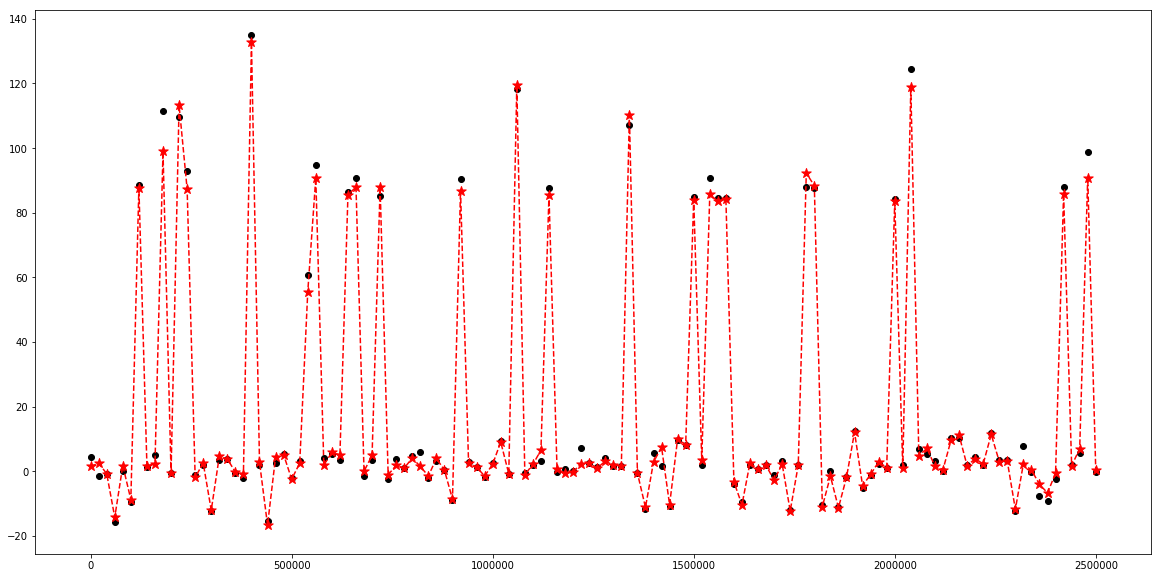

In [0]:
# Plot

idx = df_subs['submission_6'].index.values
step = 20000

plt.figure(figsize=(20,10))
plt.scatter(idx[::step], df_subs['submission_6']['scalar_coupling_constant'][::step],c='k')
plt.scatter(idx[::step], df_subs['submission_4']['scalar_coupling_constant'][::step],c='r',marker='*',s=100)
plt.plot(idx[::step], df_subs['submission_4']['scalar_coupling_constant'][::step], 'r--')

plt.show()

In [0]:
idx = df_subs['submission_6'].index.values
idx[::20000]

numpy.ndarray